In [ ]:
# Import required libraries

import datacube
import ipywidgets as widgets
import pandas as pd
import numpy as np
import folium 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import branca.colormap as cm

In [ ]:
dc = datacube.Datacube(app = "FB_ODC")
products = dc.list_products()['name'].to_list()

In [ ]:
# Definition of the widgets that allow the user to select the parameters for data selection with the load function

In [ ]:
day_options = []
for i in range(1,32,1):
    day_options.append(str(i))

month_options = []
for i in range(1,13,1):
    month_options.append(str(i))
day_options = pd.DataFrame(day_options, columns=['day'])
month_options = pd.DataFrame(month_options, columns=['month'])
year_options = ['2020', '2021']
year_options = pd.DataFrame(year_options, columns=['year'])
product_options = pd.DataFrame(products, columns=['products'])

day = widgets.SelectMultiple(options=['---']+list(day_options['day'].unique()), description='Day:')
month = widgets.SelectMultiple(options=['---']+list(month_options['month'].unique()), description='Month:')
year = widgets.SelectMultiple(options=['---']+list(year_options['year'].unique()), description='Year:')
prod = widgets.SelectMultiple(options=['---']+list(product_options['products'].unique()), description='Product:')

print('Select a Product from datacube:')
display(prod)

print('Select a time interval:')
display(year, month, day)

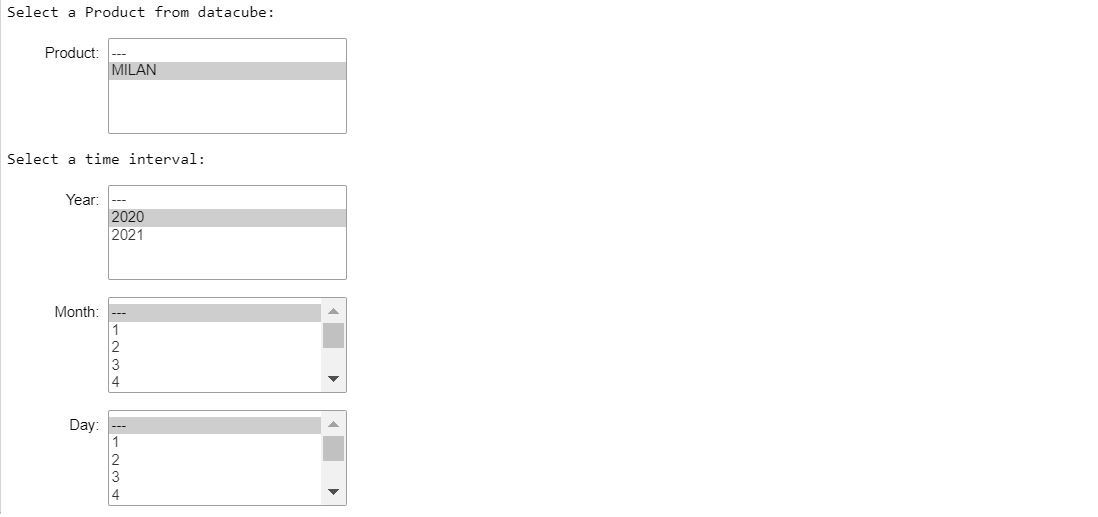

In [ ]:
p = prod.value[0]
y = year.value[0]
m = month.value[0]
d = day.value[0]

if ((y!='---') and (m=='---') and (d=='---')):
    time_range = y
else:
    if ((y!='---') and (m!='---') and (d=='---')):
        time_rage = y + '-' + m
    else:
        if ((y!='---') and (m!='---') and (d!='---')):
            time_range = y + '-' + m + '-' + d
        else:
            print('Error in time selection, please choose a correct time interval')

In [ ]:
# The function dc.load allows to load all dataset from the selected product that matches the given spatial and temporal extent
latitude_bounds = (45.311597470877999, 45.627484179430269)
longitude_bounds = (8.995056152343800, 9.549865722656120)
ds = dc.load(product = p,
             time = time_range,
             group_by = 'solar_day')

In [ ]:
print(ds)
print(type(ds))

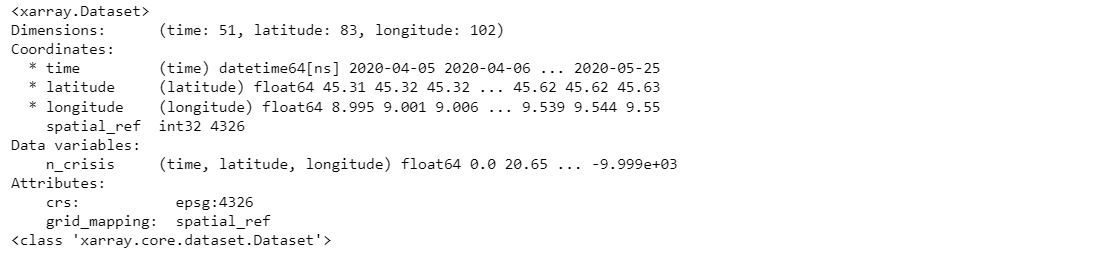

In [ ]:
# The following functions allow to explore the ranges of DataSet's dimensions (latitude, longitude, time)

latitude_extents = (min(ds['latitude'].values),max(ds['latitude'].values))
longitude_extents = (min(ds['longitude'].values),max(ds['longitude'].values))
time_extents = (min(ds['time'].values),max(ds['time'].values))
latitude_extents = (min(ds['latitude'].values),max(ds['latitude'].values))
longitude_extents = (min(ds['longitude'].values),max(ds['longitude'].values))
time_extents = (min(ds['time'].values),max(ds['time'].values))
print('Latitude bounds: ', latitude_extents)
print('Longitude_bounds: ', longitude_extents)
print('Time_range: ', time_extents)

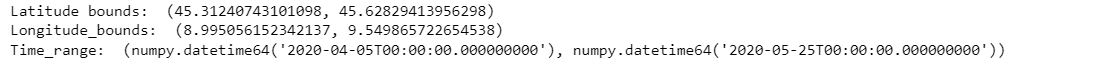

# DATA ANALYSIS

# Plot of mean/variance/median over time

In [ ]:
# User through a widget selects an operator between mean, variance and median.
# The function 'plot_time-op' returns for each time the result of the chosen operator on the data ('n_crisis')
# Results of the function are returned as lists, in this example are plotted in a graph

options = ['Mean', 'Variance', 'Median']
df_options = pd.DataFrame(options, columns=['options'])
sel_operator = widgets.SelectMultiple(
    options=['---']+list(df_options['options'].unique()),
    description='Operator:'
)
display(sel_operator)

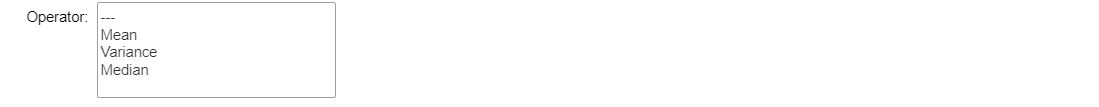

In [ ]:
operator = sel_operator.value[0]

In [ ]:
def plot_time_op(operator, ds):
    time_list = ds.time.to_dataframe()
    time_list = time_list['time'].tolist()
    y = []
    for i in time_list:
        df_i = ds.sel(time=i).to_dataframe()
        df_i = df_i.reset_index().replace(to_replace=-9999, value=0)
        if operator == 'Mean':
            mean_i = df_i['n_crisis'].mean()
            y.append(mean_i)
        elif operator == 'Variance':
            std_i = df_i['n_crisis'].std()
            y.append(std_i)
        elif operator == 'Median':
            med_i = df_i['n_crisis'].median()
            y.append(med_i)
    return [time_list, y]

In [ ]:
axes = plot_time_op(operator, ds)
x = axes[0]
y = axes[1]
title = operator + ' of people per time'

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y,
        '-',
        color='purple')
ax.set(xlabel="Date", ylabel=operator, title=title)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
plt.show()

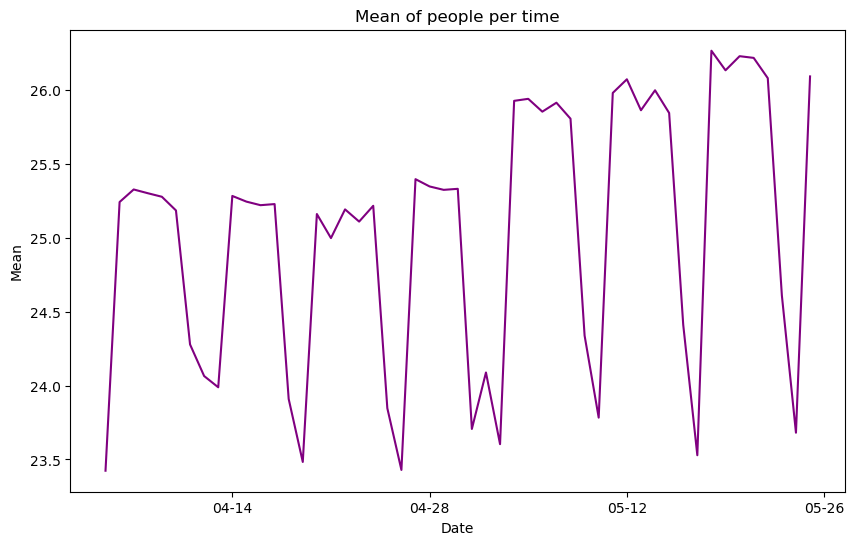

# Time Series

In [ ]:
# Section that allows to plot the time series of a selected point

# The user has the possibility to extract from the dataset the number of people present in a certain point il the chosen
# time interval (specified for the load function)

# The coordinates of the points are passed to the function, that evaluates the nearest point of the grid and extract the selected
# information. The results are then plot in a (time - )

# The user inserts the precise coordinates of a point, the function temporal_series extraxt from the dataset the number of people
# present in that point in the chosen time interval

# The user can type directly the coordinates in the following form or can choose a location from the list provided below

lat_widg = widgets.FloatText(value='0.0', description='Latitude:')
lon_widg = widgets.FloatText(value='0.0', description='Longitude:')
display(lat_widg, lon_widg)

In [ ]:
lat = lat_widg.value
lon = lon_widg.value

In [ ]:
# A series of coordinents of relevant spots of Milan is provided to the user

landmarks = pd.read_csv('C:/git/FB_ODC_2021/landmarks.csv')

df_options = landmarks[['Place']]
zone_operator = widgets.SelectMultiple(
    options=['---']+list(df_options['Place'].unique()),
    description='Zone:'
)
display(zone_operator)

In [ ]:
zone = zone_operator.value[0]
mask = landmarks[landmarks['Place'] == zone].reset_index()
lat = mask['lat'][0]
lon = mask['lon'][0]

In [ ]:
def temporal_series(ds, lat, lon):
    
    # Search for the closest latitude in the grid:
    all_lat = ds.latitude.to_dataframe()
    all_lat['delta_lat'] = abs(all_lat['latitude']-lat)
    mask_lat = all_lat[all_lat['delta_lat'] == all_lat['delta_lat'].min()]
    final_lat = mask_lat.latitude
    final_lat = final_lat.to_list()[0]
    
    # Search for the closest longitude in the grid
    all_lon = ds.longitude.to_dataframe()
    all_lon['delta_lon'] = abs(all_lon['longitude']-lon)
    mask_lon = all_lon[all_lon['delta_lon'] == all_lon['delta_lon'].min()]
    final_lon = mask_lon.longitude
    final_lon = final_lon.to_list()[0]
    
    df = ds.sel(latitude=final_lat, longitude=final_lon).to_dataframe().reset_index()
    df = df[['time', 'n_crisis']]
    df = df.replace(to_replace=-9999, value=0)
    return df

In [ ]:
temp_df = temporal_series(ds, lat, lon)
x = temp_df['time']
y = temp_df['n_crisis']

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10,6))
title = 'Time series for point: ('+str(lat)+','+str(lon)+')'
ax.plot(x, y,
        '-',
        color='purple')
ax.set(xlabel="Date", ylabel='Number of people', title=title)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
plt.show()

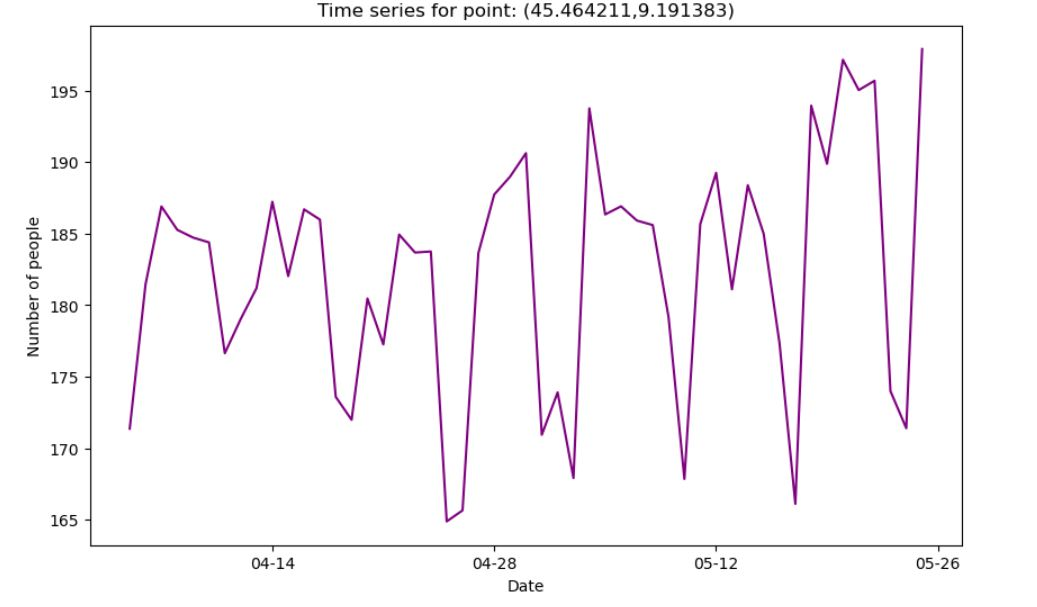

# Mean/variance/median of each point over time

In [ ]:
display(sel_operator)

In [ ]:
operator = sel_operator.value[0]

In [ ]:
# The following function allow to create a grid, each point of the grid contains the mean/variance/median 
# of the registered value across time interval
def grid_of_op(operator, ds):
    lon_list = ds.longitude.to_dataframe()
    lon_list = lon_list['longitude'].tolist()
    lat_list = ds.latitude.to_dataframe()
    lat_list = lat_list['latitude'].tolist()
    
    grid_op = pd.DataFrame(columns = ['latitude', 'longitude', 'value'])
    for i in lat_list:
        for j in lon_list:
            df_i = ds.sel(longitude=j, latitude=i).to_dataframe().reset_index().replace(to_replace=-9999, value=0)
            if operator == 'Mean':
                val = df_i['n_crisis'].mean()
            elif operator == 'Variance':
                val = df_i['n_crisis'].std()
            elif operator == 'Median':
                val = df_i['n_crisis'].median()
            row = pd.DataFrame([[i, j, val]], columns = ['latitude', 'longitude', 'value'])
            grid_op = grid_op.append(row)
    return grid_op

In [ ]:
grid = grid_of_op(operator, ds)
grid = grid.reset_index().drop(columns=['index'])

In [ ]:
#A first visualization of the data obtained is given with the matplotlib scatter tool
df = grid
title = operator + ' of people per time for each point'
fig = plt.scatter(x=df['longitude'], y=df['latitude'], marker = 'o', c = df['value'])
plt.title(title)
plt.savefig('./prova.tiff')
plt.show(fig)

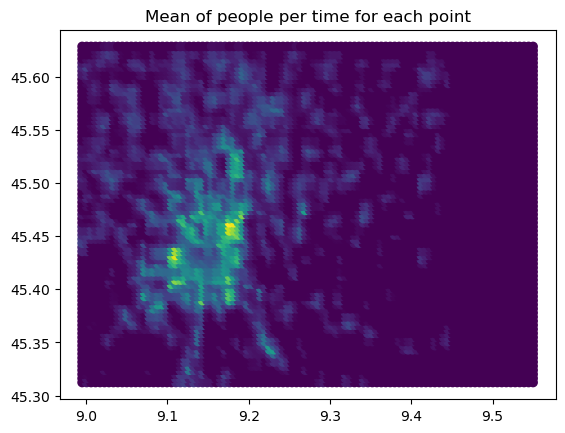

In [ ]:
# Data visualization is poor and difficult to be read and understand
# In order to give a better representation we decided to use the folium library to build an interactive map of the data

# We select only not-null values 
df = df[df['value']!=0].reset_index()
df = df[['latitude', 'longitude', 'value']]

In [ ]:
# Creation of the map and of the color scale used for data visualization
m = folium.Map(location=[45.4773, 9.1815], zoom_start=11)
cmap = cm.LinearColormap(colors=['yellow','green', 'red', 'blue'], vmin=df['value'].min(), vmax=df['value'].max(), caption='Density Population')
cmap

In [ ]:
lat = list(df.latitude)
lon = list(df.longitude)
v = list(df.value)
for loc, p in zip(zip(lat, lon), v):
    folium.Circle(
        location=loc,
        radius=20,
        fill=True,
        color=cmap(p),
        fill_opacity=0.7
    ).add_to(m)
m.add_child(cmap)

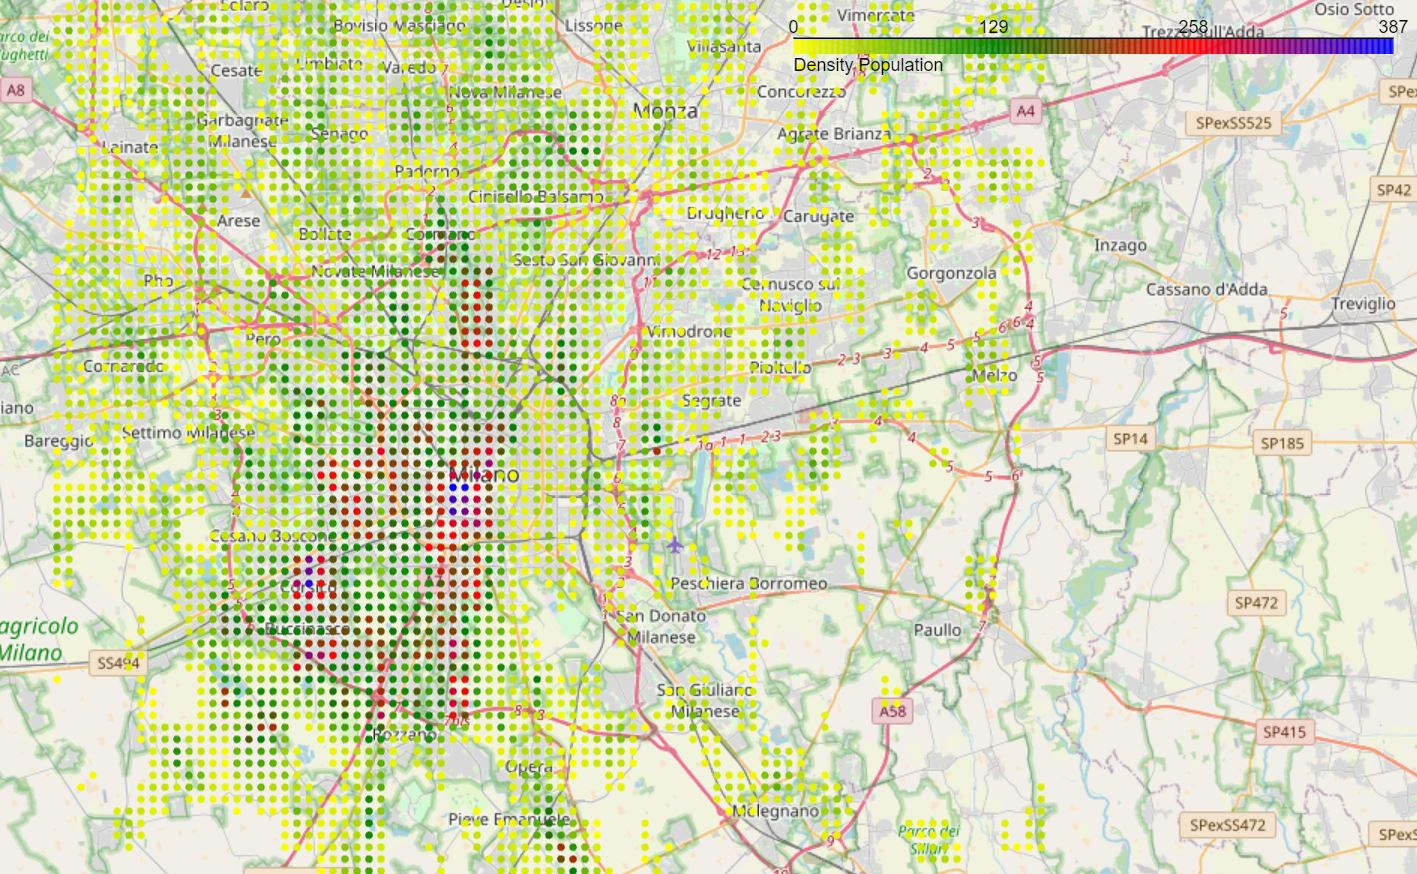

In [ ]:
m.save('map.html')

# Further Analysis on Milano's districts

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import geopandas as gpd

In [ ]:
df = pd.read_csv('C:/git/FB_ODC_2021/cubeenv/grid_mean.csv')
df

In [ ]:
sample_df = df

# json file containing the boundaries of municipalities is loades as GeoDataFrame
mun = gpd.read_file("C:/git/FB_ODC_2021/MI_ZONES.geojson")
# Reprojection of the GeoDataFrame to the correct crs
mun = mun.to_crs("EPSG:4326")

In [ ]:
from shapely.geometry import Point

# Creation of the GeoDataFrame containing the points
points = []
for i in range(len(df)):
    Pi = Point(df['longitude'][i], df['latitude'][i])
    points.append(Pi)

df['geometry'] = points
gdf = gpd.GeoDataFrame(df, geometry = 'geometry', crs='epsg:4326')

In [ ]:
gdf

In [ ]:
# Example of plot of the GeoDataFrame, some points are inside the Milano's boundaries
sample_gdf = gdf.sample(20)

fig, ax = plt.subplots(figsize = (10,8))
fig = mun.boundary.plot(ax=ax, edgecolor = 'black')
fig = sample_gdf.plot(ax=ax)

plt.show(fig)

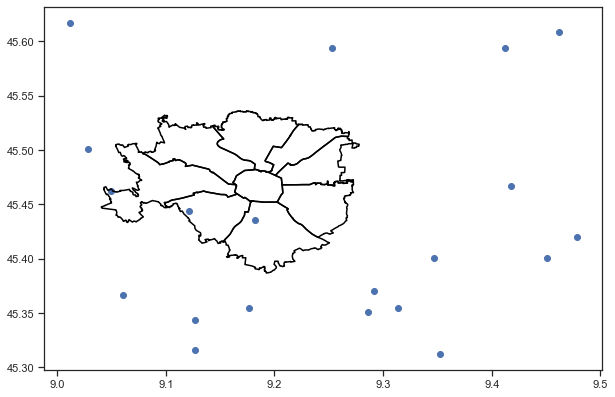

In [ ]:
# Spatial join --> assoiation of the point to the district the belong to
join = gpd.sjoin(gdf, mun, how="inner", op="within").reset_index()

In [ ]:
join = join[['latitude', 'longitude', 'value', 'MUNICIPIO', 'AREA', 'geometry']]
join

In [ ]:
# Evaluation f the mean number of people per district
tot = []
mean_tot = []

for i in range(len(mun)):
    m_i = mun['MUNICIPIO'][i]
    mask = join[join['MUNICIPIO'] == m_i]
    v_i = mask['value'].sum()
    med_i = mask['value'].mean()
    tot.append(v_i)
    mean_tot.append(med_i)

mun['tot_people'] = tot
mun['media_district'] = mean_tot

In [ ]:
import contextily as ctx

# Plot of the district, according to the mean number of people contained
fig, ax = plt.subplots(figsize = (12,10))

mun.plot(column='media_district', cmap='Reds', linewidth=1, ax=ax, 
                  edgecolor='0.3', alpha = 0.8)    

sm = plt.cm.ScalarMappable(cmap='Reds' , 
            norm=plt.Normalize(vmin=min(mun['media_district']), 
                               vmax=max(mun['media_district'])))

ax.axis('off')
cbar = fig.colorbar(sm)
ctx.add_basemap(ax, crs='EPSG:4326')
                     
plt.show()

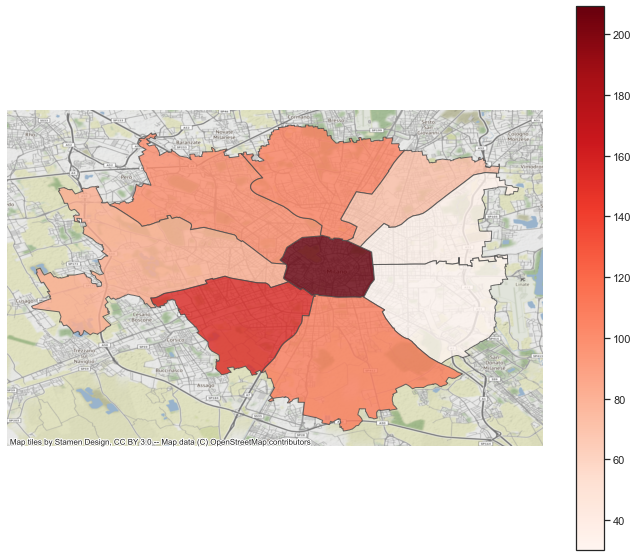